# Import

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import spacy
import re


# Setup

In [22]:
# Set seeds
np.random.seed(42)

# Read data

In [23]:
df_train = pd.read_csv("rct_oncology_train.csv", converters={"accept": literal_eval})
df_test = pd.read_csv("rct_oncology_test.csv", converters={"accept": literal_eval})

In [24]:
# Create dummy variables from accept column
df_train = df_train.join(pd.get_dummies(df_train["accept"].explode()).groupby(level=0).sum())
df_test = df_test.join(pd.get_dummies(df_test["accept"].explode()).groupby(level=0).sum())


# Dataset characteristics

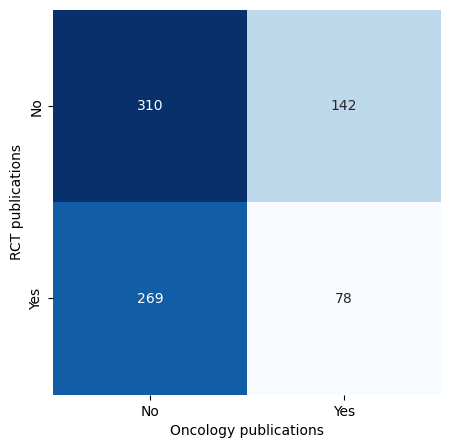

In [42]:
# Visualize the distribution of ONCOLOGY and RCT in the training set
fig = plt.figure(figsize=(5, 5))
train_cross_tab = pd.crosstab(df_train["RCT"], df_train["ONCOLOGY"])

sns.heatmap(train_cross_tab, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Oncology publications")
plt.ylabel("RCT publications")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/training_characteristics.png", dpi=300, bbox_inches="tight")

In [43]:
# Calculate percentages of respective fields in the training set

oncology_and_rct_train = 100 * train_cross_tab.loc[1, 1] / df_train.shape[0]
oncology_not_rct_train = 100 * train_cross_tab.loc[0, 1] / df_train.shape[0]
rct_not_oncology_train = 100 * train_cross_tab.loc[1, 0] / df_train.shape[0]
neither_train = 100 * train_cross_tab.loc[0, 0] / df_train.shape[0]
oncology_train = 100 * (oncology_and_rct_train + oncology_not_rct_train) / 100
rct_train = 100 * (oncology_and_rct_train + rct_not_oncology_train) / 100

print(
    f"Percentage of publications that were oncology rcts: {oncology_and_rct_train:.2f}%"
)
print(f"Percentage of  publications that covered oncology topics but were no rcts: {oncology_not_rct_train:.2f}%")
print(f"Percentage of publications that were rcts but did not cover oncology topics: {rct_not_oncology_train:.2f}%")
print(f"Percentage of publications that were neither rcts nor oncology focused: {neither_train:.2f}%")
print(f"Percentage of publications that covered oncology topics: {oncology_train:.2f}%")
print(f"Percentage of publications that were rcts: {rct_train:.2f}%")

Percentage of publications that were oncology rcts: 9.76%
Percentage of  publications that covered oncology topics but were no rcts: 17.77%
Percentage of publications that were rcts but did not cover oncology topics: 33.67%
Percentage of publications that were neither rcts nor oncology focused: 38.80%
Percentage of publications that covered oncology topics: 27.53%
Percentage of publications that were rcts: 43.43%


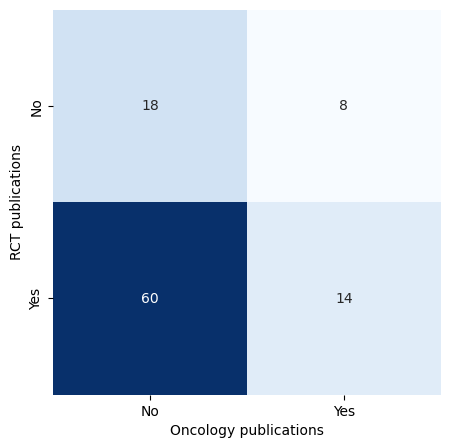

In [47]:
# Visualize the distribution of LOCAL and METASTATIC in the test set
fig = plt.figure(figsize=(5, 5))
test_cross_tab = pd.crosstab(df_test["RCT"], df_test["ONCOLOGY"])
sns.heatmap(test_cross_tab, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Oncology publications")
plt.ylabel("RCT publications")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/test_characteristics.png", dpi=300, bbox_inches="tight")

In [48]:
# Calculate percentages of respective fields in the test set

oncology_and_rct_test = 100 * test_cross_tab.loc[1, 1] / df_test.shape[0]
oncology_not_rct_test = 100 * test_cross_tab.loc[0, 1] / df_test.shape[0]
rct_not_oncology_test = 100 * test_cross_tab.loc[1, 0] / df_test.shape[0]
neither_test = 100 * test_cross_tab.loc[0, 0] / df_test.shape[0]
oncology_test = 100 * (oncology_and_rct_test + oncology_not_rct_test) / 100
rct_test = 100 * (oncology_and_rct_test + rct_not_oncology_test) / 100

print(
    f"Percentage of publications that were oncology rcts: {oncology_and_rct_test:.2f}%"
)
print(f"Percentage of  publications that covered oncology topics but were no rcts: {oncology_not_rct_test:.2f}%")
print(f"Percentage of publications that were rcts but did not cover oncology topics: {rct_not_oncology_test:.2f}%")
print(f"Percentage of publications that were neither rcts nor oncology focused: {neither_test:.2f}%")
print(f"Percentage of publications that covered oncology topics: {oncology_test:.2f}%")
print(f"Percentage of publications that were rcts: {rct_test:.2f}%")



Percentage of publications that were oncology rcts: 14.00%
Percentage of  publications that covered oncology topics but were no rcts: 8.00%
Percentage of publications that were rcts but did not cover oncology topics: 60.00%
Percentage of publications that were neither rcts nor oncology focused: 18.00%
Percentage of publications that covered oncology topics: 22.00%
Percentage of publications that were rcts: 74.00%


# Testing

## Make ML predictions

In [26]:
# Load model
rct_oncology_model = spacy.load("./rct_oncology_publication_v2/model-best")

In [27]:
# Predict on the test set
def predict(text):
    prediction = rct_oncology_model(text)
    return prediction.cats

df_test["ML_prediction"] = df_test["text"].apply(predict)

# Create columns from the prediction dictionary
df_test["RCT_PREDICTED_ML"] = df_test["ML_prediction"].apply(
    lambda x: 1 if x["RCT"] > 0.5 else 0
)
df_test["ONCOLOGY_PREDICTED_ML"] = df_test["ML_prediction"].apply(
    lambda x: 1 if x["ONCOLOGY"] > 0.5 else 0
)

## Evaluate performance

ML predictions

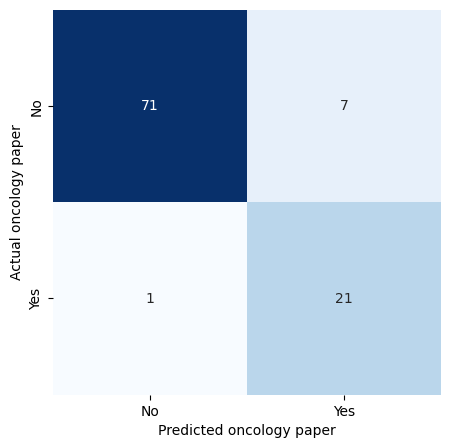

In [28]:
# Create confusion matrix of predicted and actual values for LOCAL
confusion_matrix = pd.crosstab(df_test["ONCOLOGY"], df_test["ONCOLOGY_PREDICTED_ML"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted oncology paper")
plt.ylabel("Actual oncology paper")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
# fig.savefig("plots/confusion_matrix_local_ML.png", dpi=300, bbox_inches="tight")

In [31]:
# Calculate the accuracy of the ML prediction for ONCOLOGY
accuracy_oncology_ML = (
    np.sum(df_test["ONCOLOGY"] == df_test["ONCOLOGY_PREDICTED_ML"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_oncology_ML_std = np.sqrt(
    accuracy_oncology_ML * (1 - accuracy_oncology_ML) / df_test.shape[0]
)
accuracy_oncology_ML_CI = 1.96 * accuracy_oncology_ML_std
print(
    f"Accuracy of ML prediction for ONCOLOGY: {accuracy_oncology_ML:.2f} (95% CI: {accuracy_oncology_ML - accuracy_oncology_ML_CI:.2f} - {accuracy_oncology_ML + accuracy_oncology_ML_CI:.2f})"
)

# Calculate the precision of the ML prediction for ONCOLOGY
precision_oncology_ml = (
    np.sum(
        (df_test["ONCOLOGY"] == 1) & (df_test["ONCOLOGY_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["ONCOLOGY_PREDICTED_ML"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_oncology_ml_std = np.sqrt(
    precision_oncology_ml * (1 - precision_oncology_ml) / np.sum(df_test["ONCOLOGY_PREDICTED_ML"] == 1)
)
precision_local_ml_CI = 1.96 * precision_oncology_ml_std
print(f"Precision of ML prediction for ONCOLOGY: {precision_oncology_ml:.2f} (95% CI: {precision_oncology_ml - precision_local_ml_CI:.2f} - {precision_oncology_ml + precision_local_ml_CI:.2f})")

# Calculate the recall of the ML prediction for ONCOLOGY
recall_oncology_ml = (
    np.sum(
        (df_test["ONCOLOGY"] == 1) & (df_test["ONCOLOGY_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["ONCOLOGY"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_oncology_ml_std = np.sqrt(
    recall_oncology_ml * (1 - recall_oncology_ml) / np.sum(df_test["ONCOLOGY"] == 1)
)
recall_local_ml_CI = 1.96 * recall_oncology_ml_std
print(
    f"Recall of ML prediction for ONCOLOGY: {recall_oncology_ml:.2f} (95% CI: {recall_oncology_ml - recall_local_ml_CI:.2f} - {recall_oncology_ml + recall_local_ml_CI:.2f})"
)

# Calculate the F1 score of the ML prediction for ONCOLOGY
f1_oncology_ml = 2 * precision_oncology_ml * recall_oncology_ml / (precision_oncology_ml + recall_oncology_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_oncology_ml_std = np.sqrt(
    f1_oncology_ml * (1 - f1_oncology_ml) / df_test.shape[0]
)
f1_oncology_ml_CI = 1.96 * f1_oncology_ml_std
print(f"F1 score of ML prediction for ONCOLOGY: {f1_oncology_ml:.2f} (95% CI: {f1_oncology_ml - f1_oncology_ml_CI:.2f} - {f1_oncology_ml + f1_oncology_ml_CI:.2f})")



Accuracy of ML prediction for ONCOLOGY: 0.92 (95% CI: 0.87 - 0.97)
Precision of ML prediction for ONCOLOGY: 0.75 (95% CI: 0.59 - 0.91)
Recall of ML prediction for ONCOLOGY: 0.95 (95% CI: 0.87 - 1.04)
F1 score of ML prediction for ONCOLOGY: 0.84 (95% CI: 0.77 - 0.91)


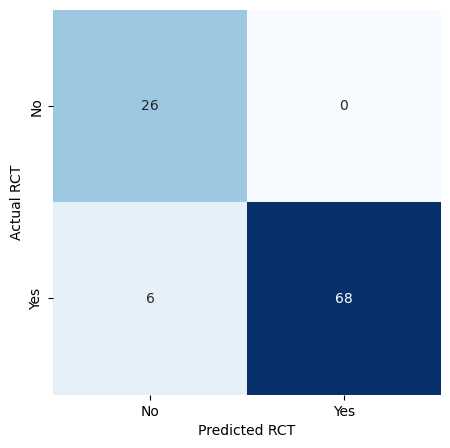

In [30]:
# Create confusion matrix of predicted and actual values for METASTATIC
confusion_matrix = pd.crosstab(df_test["RCT"], df_test["RCT_PREDICTED_ML"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted RCT")
plt.ylabel("Actual RCT")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
# fig.savefig("plots/confusion_matrix_metastatic_ML.png", dpi=300, bbox_inches="tight")

In [32]:
# Calculate the accuracy of the ML prediction for RCT
accuracy_rct_ml = (
    np.sum(df_test["RCT"] == df_test["RCT_PREDICTED_ML"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_rct_ml_std = np.sqrt(
    accuracy_rct_ml * (1 - accuracy_rct_ml) / df_test.shape[0]
)
accuracy_rct_ml_CI = 1.96 * accuracy_rct_ml_std
print(
    f"Accuracy of ML prediction for RCT: {accuracy_rct_ml:.2f} (95% CI: {accuracy_rct_ml - accuracy_rct_ml_CI:.2f} - {accuracy_rct_ml + accuracy_rct_ml_CI:.2f})"
)

# Calculate the precision of the ML prediction for RCT
precision_rct_ml = (
    np.sum(
        (df_test["RCT"] == 1) & (df_test["RCT_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["RCT_PREDICTED_ML"] == 1)
)

# Estimate the 95 % confidence interval for the precision
precision_rct_ml_std = np.sqrt(
    precision_rct_ml * (1 - precision_rct_ml) / np.sum(df_test["RCT_PREDICTED_ML"] == 1)
)
precision_rct_ml_CI = 1.96 * precision_rct_ml_std
print(f"Precision of ML prediction for RCT: {precision_rct_ml:.2f} (95% CI: {precision_rct_ml - precision_rct_ml_CI:.2f} - {precision_rct_ml + precision_rct_ml_CI:.2f})")

# Calculate the recall of the ML prediction for RCT
recall_rct_ml = (
    np.sum(
        (df_test["RCT"] == 1) & (df_test["RCT_PREDICTED_ML"] == 1)
    )
    / np.sum(df_test["RCT"] == 1)
)

# Estimate the 95 % confidence interval for the recall
recall_rct_ml_std = np.sqrt(
    recall_rct_ml * (1 - recall_rct_ml) / np.sum(df_test["RCT"] == 1)
)
recall_rct_ml_CI = 1.96 * recall_rct_ml_std
print(
    f"Recall of ML prediction for RCT: {recall_rct_ml:.2f} (95% CI: {recall_rct_ml - recall_rct_ml_CI:.2f} - {recall_rct_ml + recall_rct_ml_CI:.2f})"
)

# Calculate the F1 score of the ML prediction for RCT
f1_rct_ml = 2 * precision_rct_ml * recall_rct_ml / (precision_rct_ml + recall_rct_ml)

# Estimate the 95 % confidence interval for the F1 score
f1_rct_ml_std = np.sqrt(
    f1_rct_ml * (1 - f1_rct_ml) / df_test.shape[0]
)
f1_rct_ml_CI = 1.96 * f1_rct_ml_std
print(f"F1 score of ML prediction for RCT: {f1_rct_ml:.2f} (95% CI: {f1_rct_ml - f1_rct_ml_CI:.2f} - {f1_rct_ml + f1_rct_ml_CI:.2f})")



Accuracy of ML prediction for RCT: 0.94 (95% CI: 0.89 - 0.99)
Precision of ML prediction for RCT: 1.00 (95% CI: 1.00 - 1.00)
Recall of ML prediction for RCT: 0.92 (95% CI: 0.86 - 0.98)
F1 score of ML prediction for RCT: 0.96 (95% CI: 0.92 - 1.00)


# Detect tumor entity

In [104]:
def assign_tumor_type(row):
    tumor_type_array = []
    title = row["title"].lower()
    # Gynecological
    if re.search(r"\bbreast", title):
        tumor_type_array.append("Breast")
    if re.search(r"dcis", title) or re.search(r"ductal carcinoma in situ", title):
        if not "Breast" in tumor_type_array:
            tumor_type_array.append("Breast")
    if re.search(r"mammogr", title):
        if not "Breast" in tumor_type_array:
            tumor_type_array.append("Breast")
    if re.search(r"ovarian", title) or re.search(r" ovar", title):
        if not re.search(r"ovar.*suppre", title):
            tumor_type_array.append("Ovary")
    if re.search(r"cervic", title) or re.search(r"cervix", title):
        tumor_type_array.append("Cervix")
    if re.search(r"endometr", title) or re.search(r" uter", title):
        tumor_type_array.append("Endometrial")
    if re.search(r"vulv", title):
        tumor_type_array.append("Vulva")

    # Lung
    if re.search(r"non[- ]small[- ]cell[- ]lung", title) or re.search(r" nsclc", title):
        tumor_type_array.append("NSCLC")
    if re.search(r"small[- ]cell[- ]lung", title) or re.search(r" sclc", title):
        if not "NSCLC" in tumor_type_array:
            tumor_type_array.append("SCLC")
    if re.search(r"\blung", title):
        if not "NSCLC" in tumor_type_array and not "SCLC" in tumor_type_array:
            tumor_type_array.append("Lung")
    if re.search(r"\bthym", title):
        tumor_type_array.append("Thymoma")

    # Urothelial
    if (
        re.search(r"\bbladder", title)
        or re.search(r"urothelial", title)
        or re.search(r"urethr", title)
    ):
        tumor_type_array.append("Urothelia")
    if re.search(r"renal", title) or re.search(r"kidney", title) or re.search(r"\brcc", title):
        tumor_type_array.append("Renal")
    if re.search(r"prostat", title):
        tumor_type_array.append("Prostate")
    if re.search(r"\bgerm", title) and not re.search(r"german", title) and not re.search(r"germ ?line", title):
        tumor_type_array.append("Germ cell")
    if re.search(r"seminoma", title) and not re.search(r"non[- ]?seminoma", title):
        tumor_type_array.append("Seminoma")

    # GI
    if re.search(r"esophag", title):
        tumor_type_array.append("Esophageal")
    if re.search(r"gastric", title) or re.search(r"stomach", title):
        if not "Esophageal" in tumor_type_array:
            tumor_type_array.append("Gastric")
    if re.search(r"hepatocellular", title) or re.search(r"hcc", title):
        tumor_type_array.append("Hepatocellular")
    if re.search(r"pancreatic", title) or re.search(r" pancreas", title):
        tumor_type_array.append("Pancreas")
    if re.search(r"cholangio", title) or re.search(r"bile duct", title) or re.search(r"biliary", title): 
        tumor_type_array.append("Cholangiocarcinoma")
    if re.search(r"rectal", title) or re.search(r" crc", title) or re.search(r"\bcolo", title):
        if not re.search(r"colony", title):
            tumor_type_array.append("Colorectal")
    if re.search(r"\banal\b", title):
        tumor_type_array.append("Anal")
    if re.search("gastro[- ]?intestinal stro", title):
        tumor_type_array.append("GIST")

    # Skin and soft tissue
    if re.search(r"melanoma", title):
        tumor_type_array.append("Melanoma")
    if re.search(r"sarcoma", title):
        tumor_type_array.append("Sarcoma")
    if re.search(r"mesothelioma", title):
        tumor_type_array.append("Mesothelioma")
    if re.search(r"basal", title):
        tumor_type_array.append("Basal cell")
    if re.search(r"merkel", title):
        tumor_type_array.append("Merkel cell")

    # Neuro
    if re.search(r"glioblastoma", title):
        tumor_type_array.append("High-grade glioma")
    if re.search(r"anaplastic glioma", title) or re.search(r"anaplastic astrocytoma", title):
        tumor_type_array.append("High-grade glioma")
    if re.search(r"diffuse", title) and re.search(r"glioma", title) and (re.search(r"pontine", title) or re.search(r"midline", title)):
        tumor_type_array.append("High-grade glioma")
    if re.search(r"dipg", title):
        tumor_type_array.append("High-grade glioma")
    if re.search(r"high[- ]grade[- ]glioma", title):
        tumor_type_array.append("High-grade glioma")
    if re.search(r"oligodendroglioma", title):
        tumor_type_array.append("Low-grade glioma")
    if re.search(r"diffuse astrocytoma", title) or re.search(r"diffuse glioma", title):
        if not "High-grade glioma" in tumor_type_array:
            tumor_type_array.append("Low-grade glioma")
    if re.search(r"low[- ]grade[- ]glioma", title):
        tumor_type_array.append("Low-grade glioma")
    if re.search(r"glioma", title) or re.search(r"astrocytoma", title) or re.search(r"ependym", title):
        if not "High-grade glioma" in tumor_type_array and not "Low-grade glioma" in tumor_type_array:
            tumor_type_array.append("Glioma")
    if re.search(r"meningioma", title) or re.search(r"meningeoma", title):
        tumor_type_array.append("Meningioma")
    if re.search(r"medulloblastoma", title):
        tumor_type_array.append("Medulloblastoma")
    if re.search(r"pituitar", title):
        tumor_type_array.append("Pituitary")
    if re.search(r"schwannoma", title):
        tumor_type_array.append("Schwannoma")
    if re.search(r"neuroblastoma", title):
        tumor_type_array.append("Neuroblastoma")

    # Head and neck
    if (
        re.search(r"\boral.*cavity", title)
        or re.search(r"oral canc", title)
        or re.search(r" tongue", title)
        or re.search(r" palat", title or re.search(r" mouth", title))
    ):
        tumor_type_array.append("Head & neck")
    if re.search(r"laryn", title) and not "Head & neck" in tumor_type_array:
        tumor_type_array.append("Head & neck")
    if re.search(r"oropha", title) and not "Head & neck" in tumor_type_array:
        tumor_type_array.append("Head & neck")
    if re.search(r"nasophary", title) and not "Head & neck" in tumor_type_array:
        tumor_type_array.append("Head & neck")

    if re.search(r"salivary", title) and not "Head & neck" in tumor_type_array:
        tumor_type_array.append("Head & neck")
    if re.search(r"thyro", title) and not "Head & neck" in tumor_type_array:
        tumor_type_array.append("Thyroid")
    if re.search(r"head.*neck", title) and not "Head & neck" in tumor_type_array:
        tumor_type_array.append("Head & neck")

    # Hematological
    if re.search(r"hodgk", title) and not re.search(r"non[- ]hodgk", title):
        tumor_type_array.append("Hodgkin lymphoma")
    if re.search(r"myeloma", title):
        tumor_type_array.append("Myeloma")
    if re.search(r"chronic lymphocytic leuka?emia", title) or re.search(r"cll", title):
        tumor_type_array.append("CLL")
    if re.search(r"lymphoma", title):
        if not "Hodgkin lymphoma" in tumor_type_array and not "Myeloma" in tumor_type_array and not "CLL" in tumor_type_array:
            tumor_type_array.append("Other non-Hodgkin lymphoma")
    if re.search(r"acute lympho.*leuka?emia", title):
        tumor_type_array.append("ALL")
    if re.search(r"acute mye.*leuka?emia", title) or re.search(r"\baml", title):
        tumor_type_array.append("AML")
    if re.search(r"chronic mye.* leuka?emia", title) or re.search(r"\bcml", title):
        tumor_type_array.append("CML")
    if re.search(r"leuka?emia", title) and not re.search(r"leuka?emia group", title):
        if not "ALL" in tumor_type_array and not "AML" in tumor_type_array and not "CML" in tumor_type_array and not "CLL" in tumor_type_array:
            tumor_type_array.append("Other leukemia")
    if re.search(r"myelodysplastic", title) or re.search(r"\bmds", title):
        tumor_type_array.append("MDS")

    # Metastases
    if re.search(r"bone metast", title):
        tumor_type_array.append("Bone metastases")
    if re.search(r"brain metast", title):
        tumor_type_array.append("Brain metastases")
    if re.search(r"metast", title) or re.search(r"effusion", title):
        tumor_type_array.append("General metastases")

    return tumor_type_array

In [105]:
def assign_family(row):
    tumor_entities = row["tumor_type"]
    for tumor_entity in tumor_entities:
        if tumor_entity in ["Breast", "Ovary", "Cervix", "Endometrial", "Vulva"]:
            return "Gynecological"
        if tumor_entity in ["NSCLC", "SCLC", "Lung", "Thymoma"]:
            return "Lung/Thoracic"
        if tumor_entity in ["Urothelia", "Renal", "Prostate", "Germ cell", "Seminoma"]:
            return "Urogenital"
        if tumor_entity in ["Esophageal", "Gastric", "Hepatocellular", "Pancreas", "Cholangiocarcinoma", "Colorectal", "Anal", "GIST"]:
            return "Gastrointestinal"
        if tumor_entity in ["Melanoma", "Sarcoma", "Mesothelioma", "Basal cell", "Merkel cell"]:
            return "Skin/Soft tissue"
        if tumor_entity in ["High-grade glioma", "Low-grade glioma", "Glioma", "Meningioma", "Medulloblastoma", "Pituitary", "Schwannoma", "Neuroblastoma"]:
            return "Neuro"
        if tumor_entity in ["Head & neck", "Thyroid"]:
            return "Head & neck"
        if tumor_entity in ["Hodgkin lymphoma", "Myeloma", "CLL", "Other non-Hodgkin lymphoma", "ALL", "AML", "CML", "Other leukemia", "MDS"]:
            return "Hematological"
        if tumor_entity in ["Bone metastases", "Brain metastases", "Other metastases"]:
            return "Metastases"
        
    


In [106]:
# Assign tumor type to the test set and show the distribution
df_test_onc_rcts = df_test[(df_test["ONCOLOGY"] == 1) & (df_test["RCT"] == 1)].copy()

df_test_onc_rcts["tumor_type"] = df_test_onc_rcts.apply(assign_tumor_type, axis=1)

df_test_onc_rcts["tumor_type"].value_counts()

tumor_type
[Breast]                          3
[Endometrial]                     2
[Myeloma]                         1
[MDS]                             1
[Cervix, General metastases]      1
[AML]                             1
[Gastric]                         1
[Melanoma, General metastases]    1
[Ovary]                           1
[Esophageal]                      1
[Prostate, General metastases]    1
Name: count, dtype: int64

In [107]:
# Assign family to the test set and show the distribution
df_test_onc_rcts["family"] = df_test_onc_rcts.apply(assign_family, axis=1)

df_test_onc_rcts["family"].value_counts()

family
Gynecological       7
Hematological       3
Gastrointestinal    2
Skin/Soft tissue    1
Urogenital          1
Name: count, dtype: int64

In [108]:
# Assign tumor type to the training set and show the distribution

df_train_onc_rcts = df_train[(df_train["ONCOLOGY"] == 1) & (df_train["RCT"] == 1)].copy()

df_train_onc_rcts["tumor_type"] = df_train_onc_rcts.apply(assign_tumor_type, axis=1)

df_train_onc_rcts["tumor_type"].value_counts()


tumor_type
[NSCLC]                             7
[Breast]                            7
[]                                  5
[Prostate]                          5
[Other non-Hodgkin lymphoma]        4
[Ovary]                             4
[Colorectal]                        3
[Melanoma]                          3
[Myeloma]                           3
[Hodgkin lymphoma]                  2
[Colorectal, General metastases]    2
[Gastric]                           2
[Esophageal]                        2
[Head & neck]                       2
[Hepatocellular]                    2
[ALL]                               2
[Prostate, General metastases]      2
[Renal]                             2
[General metastases]                2
[Pancreas]                          1
[CLL]                               1
[Urothelia]                         1
[Endometrial, Sarcoma]              1
[CML]                               1
[Cervix]                            1
[Melanoma, General metastases]      1
[

In [109]:
# Assign family to the training set and show the distribution
df_train_onc_rcts["family"] = df_train_onc_rcts.apply(assign_family, axis=1)

df_train_onc_rcts["family"].value_counts()

family
Gynecological       16
Hematological       14
Gastrointestinal    13
Urogenital          11
Lung/Thoracic        9
Skin/Soft tissue     6
Head & neck          2
Name: count, dtype: int64

In [110]:
# Print the title of the publications that were classified as oncology RCTs but did not have a tumor type assigned
df_train_onc_rcts[df_train_onc_rcts["tumor_type"].apply(len) == 0]["title"]



219    Effect of Sustained Smoking Cessation Counseling and Provision of Medication vs Shorter-term Counseling and Medication Advice on Smoking Abstinence in Patients Recently Diagnosed With Cancer: A Randomized Clinical Trial.
454                                                                                                Evaluation of geriatric assessment and management on the toxic effects of cancer treatment (GAP70+): a cluster-randomised study.
489                                                                                                  Real time remote symptom monitoring during chemotherapy for cancer: European multicentre randomised controlled trial (eSMART).
706                                                                                         Monthly High-Dose Vitamin D Supplementation and Cancer Risk: A Post Hoc Analysis of the Vitamin D Assessment Randomized Clinical Trial.
782                                                             Antithymocyte Globulin f